# Random Ensemble Model

In [1]:
import sys
from os.path import abspath

sys.path.append(abspath('../src/'))

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from utils import *
from baseline_convnet import BaselineConvnet
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random
from random_ensemble import RandomEnsemble

Using TensorFlow backend.


## Model description

Random Ensemble model classifies random projections of the training data in a lower dimensional space using the baseline model. 
Then classifies the original high dimensional data with a voting technique: it simply sums up the probabilities from of the classifiers for each class.
In the following examples, the model has been trained using a varying number of projections, subspace size equal to 8 (projected images of dimension 8x8).


## Recap of this notebook


Model accuracy (%): number of projections vs evaluation set


| n. projection | test set | FGSM attacks | deepfool attacks | projected gradient attacks |
| ------------- | -------- | ------------ | ---------------- | -------------------------- |
| 1 | 93.48 | 44.24 | 92.12 | 62.89 |
| 3 | 96.05 | 50.12 | 95.17 | 73.39 |
| 5 | 96.61 | 52.92 | 95.84 | 77.98 |
| 10 | 96.91 | 58.36 | 96.21 | 78.89 |

As the number of projections increases, accuracy significantly increases on both the test set and the adversaries.

# Single projection

Testing the model on a single projection.

In [7]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = RandomEnsemble(input_shape=input_shape, num_classes=num_classes, n_proj=1, size_proj=8)
classifier = model.load_classifier(
    relative_path="../trained_models/random_ensemble/random_ensemble_sum_proj=1_size=8/",
    model_name = "random_ensemble")


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)


### Test set evaluation
Evaluation of this model on the test set. Since we are only computing one projection here, the output first shows the classification report for the projection and then for the ensemble classifier (which is the same thing in this case).

In [8]:
x_test_pred = model.evaluate_test(classifier, x_test, y_test)


Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)
Test evaluation on projection  123

Testing infos:
x_test.shape =  (10000, 8, 8, 1) 
y_test.shape =  (10000, 10) 


Original test data.
Correctly classified: 9348
Incorrectly classified: 652
Test accuracy: 93.48%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.90      0.93      1032
           3       0.92      0.93      0.92      1010
           4       0.93      0.94      0.93       982
           5       0.90      0.90      0.90       892
           6       0.93      0.96      0.95       958
           7       0.95      0.94      0.94      1028
      

### Adversaries evaluation
Evaluation on different adversarial perturbations of the test set, which have been projected along the training projection direction.

In [9]:
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)


Adversarial evaluation using fgsm method.
10000 10000

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 4424
Incorrectly classified: 5576
Adversarial accuracy: 44.24%
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       980
           1       0.90      0.03      0.06      1135
           2       0.57      0.48      0.52      1032
           3       0.41      0.63      0.49      1010
           4       0.50      0.44      0.47       982
           5       0.45      0.42      0.44       892
           6       0.59      0.65      0.62       958
           7       0.64      0.14      0.23      1028
           8       0.32      0.67      0.43       974
           9       0.30      0.42      0.35      1009

   micro avg       0.44      0.44      0.44     10000
   macro avg       0.53      0.45      0.42     10000
weighted avg       0.53   

In [10]:
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')


Adversarial evaluation using deepfool method.
10000 10000

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 9212
Incorrectly classified: 788
Adversarial accuracy: 92.12%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.89      0.92      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.91      0.91       982
           5       0.88      0.88      0.88       892
           6       0.93      0.96      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.91      0.88      0.89       974
           9       0.86      0.91      0.88      1009

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92

In [11]:
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='projected_gradient',
                                        adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Adversarial evaluation using projected_gradient method.
10000 10000

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (1, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 6289
Incorrectly classified: 3711
Adversarial accuracy: 62.89%
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       980
           1       0.96      0.32      0.48      1135
           2       0.77      0.63      0.69      1032
           3       0.62      0.73      0.67      1010
           4       0.61      0.65      0.63       982
           5       0.68      0.54      0.60       892
           6       0.69      0.83      0.75       958
           7       0.87      0.33      0.48      1028
           8       0.45      0.77      0.57       974
           9       0.44      0.71      0.55      1009

   micro avg       0.63      0.63      0.63     10000
   macro avg       0.69      0.63      0.62     10000
weighted avg

## Ensemble on 3 projections
This is the ensemble model trained on 3 different random projections of the original data.

In [3]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = RandomEnsemble(input_shape=input_shape, num_classes=num_classes, n_proj=3, size_proj=8)
classifier = model.load_classifier(
    relative_path="../trained_models/random_ensemble/random_ensemble_sum_proj=3_size=8/",
    model_name = "random_ensemble")

# test set 
x_test_pred = model.evaluate_test(classifier, x_test, y_test)

# adversaries
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='projected_gradient',
                                        adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (3, 10000, 8, 8, 1)

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (3, 10000, 8, 8, 1)
Test evaluation on projection  123

Testing infos:
x_test.shape =  (10000, 8, 8, 1) 
y_test.shape =  (10000, 10) 


Original test data.
Correctly classified: 9340
Incorrectly classified: 660
Test accuracy: 93.40%
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.98      0.98      0.98      1135
       

### What's happening in the ensemble classification?

Each model is trained in the lower dimensional space of the whole dataset projection along a subset of random directions.
After training these models separately, the final ensemble classification is simply argmax of the vector containing the sum of all probabilities in each class, as shown below for a particular image.

In [4]:
# getting the arrays containing 3 projected predictions and final ensemble prediction on the first image
x_test_projected = compute_projections(x_test, random_seed=model.random_seed,
                                               n_proj=model.n_proj, size_proj=model.size_proj)

predictions = np.array([classifier.predict(x_test_projected[i]) for i, classifier in enumerate(classifier)])

np.set_printoptions(suppress=True)
print("\nPredictions on the first element by each single classifier:\n", predictions[:, 0])
#print(predictions.shape)
# sum the probabilities across all predictors
summed_predictions = np.sum(predictions, axis=0)

print("\nEnsemble prediction on the first element:\n", summed_predictions[0])
#print(summed_predictions.shape)


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (3, 10000, 8, 8, 1)

Predictions on the first element by each single classifier:
 [[0.00000069 0.00000435 0.00001448 0.00002684 0.00000251 0.00000029
  0.         0.9989423  0.00000081 0.00100779]
 [0.00000002 0.00000029 0.00000538 0.00000146 0.00000056 0.00000002
  0.         0.99991214 0.00000001 0.00008004]
 [0.00000023 0.0000005  0.00000522 0.00001784 0.00000036 0.00000032
  0.         0.99965477 0.00000032 0.00032034]]

Ensemble prediction on the first element:
 [0.00000095 0.00000515 0.00002508 0.00004614 0.00000342 0.00000063
 0.         2.9985092  0.00000114 0.00140817]


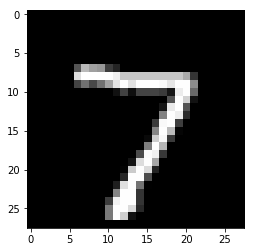

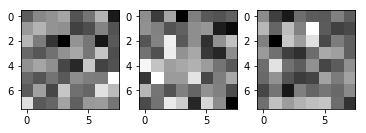

In [5]:
# original image
im = x_test[0].reshape(28,28)
plt.imshow(im, cmap='gray')
plt.show()

# projected images
im_test = [im.reshape(8, 8) for im in x_test_projected[:,0]]

f, ax = plt.subplots(1, 3, figsize=(6,6))
for i in range(3):
    ax[i].imshow(im_test[i], cmap='gray')
plt.show()

## 5 projections

In [6]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = RandomEnsemble(input_shape=input_shape, num_classes=num_classes, n_proj=5, size_proj=8)
classifier = model.load_classifier(
    relative_path="../trained_models/random_ensemble/random_ensemble_sum_proj=5_size=8/",
    model_name = "random_ensemble")

# test set 
x_test_pred = model.evaluate_test(classifier, x_test, y_test)

# adversaries
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='projected_gradient',
                                        adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)

Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (5, 10000, 8, 8, 1)

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (5, 10000, 8, 8, 1)
Test evaluation on projection  123

Testing infos:
x_test.shape =  (10000, 8, 8, 1) 
y_test.shape =  (10000, 10) 


Original test data.
Correctly classified: 9363
Incorrectly classified: 637
Test accuracy: 93.63%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.99      0.99      0.99      1135
           2       0.93      0.93      0.93      1032
           3       0.91      0.93      0.92      1010
           4       0.93      0.94      0.94       982
           5       0.93      0.89      0.91       892
           6       0.93      0


Adversarial evaluation using projected_gradient method.
10000 10000

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (5, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 7798
Incorrectly classified: 2202
Adversarial accuracy: 77.98%
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       980
           1       0.99      0.57      0.72      1135
           2       0.76      0.88      0.81      1032
           3       0.76      0.86      0.81      1010
           4       0.77      0.81      0.79       982
           5       0.80      0.72      0.76       892
           6       0.88      0.86      0.87       958
           7       0.94      0.66      0.78      1028
           8       0.53      0.92      0.67       974
           9       0.75      0.64      0.69      1009

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.81      0.78      0.78     10000
weighted avg

## 10 projections

In [13]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = RandomEnsemble(input_shape=input_shape, num_classes=num_classes, n_proj=10, size_proj=8)
classifier = model.load_classifier(
    relative_path="../trained_models/random_ensemble/random_ensemble_sum_proj=10_size=8/",
    model_name = "random_ensemble")

# test set 
x_test_pred = model.evaluate_test(classifier, x_test, y_test)

# adversaries
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='projected_gradient',
                                        adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)

Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (10, 10000, 8, 8, 1)

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (10, 10000, 8, 8, 1)
Test evaluation on projection  123

Testing infos:
x_test.shape =  (10000, 8, 8, 1) 
y_test.shape =  (10000, 10) 


Original test data.
Correctly classified: 9340
Incorrectly classified: 660
Test accuracy: 93.40%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.93      0.93      1032
           3       0.92      0.93      0.92      1010
           4       0.95      0.91      0.93       982
           5       0.92      0.89      0.91       892
           6       0.91     


Original test data.
Correctly classified: 9375
Incorrectly classified: 625
Test accuracy: 93.75%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.98      0.99      0.99      1135
           2       0.93      0.93      0.93      1032
           3       0.91      0.93      0.92      1010
           4       0.93      0.93      0.93       982
           5       0.92      0.91      0.92       892
           6       0.97      0.94      0.95       958
           7       0.93      0.95      0.94      1028
           8       0.94      0.89      0.91       974
           9       0.91      0.91      0.91      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Test evaluation on projection  67

Testing infos:
x_test.shape =  (10000, 8, 8, 1) 
y_test.shape =  (10000, 10) 


Original test data.
Correctl

# Adversarial training 

### 10 projections robust classifier

This is the same ensemble model, trained using FGSM Adversarial training on 10 projections.

In [16]:
robust_classifier = model.load_classifier(
                    relative_path="../trained_models/random_ensemble/random_ensemble_sum_proj=10_size=8_robust_fgsm/",
                    model_name="random_ensemble")

In [17]:
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(robust_classifier, x_test, y_test, method='fgsm')


Adversarial evaluation using fgsm method.
10000 10000

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (10, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 5836
Incorrectly classified: 4164
Adversarial accuracy: 58.36%
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       980
           1       1.00      0.00      0.01      1135
           2       0.60      0.87      0.71      1032
           3       0.57      0.82      0.67      1010
           4       0.67      0.56      0.61       982
           5       0.73      0.60      0.66       892
           6       0.90      0.70      0.79       958
           7       0.92      0.41      0.57      1028
           8       0.29      0.86      0.43       974
           9       0.60      0.26      0.36      1009

   micro avg       0.58      0.58      0.58     10000
   macro avg       0.72      0.59      0.57     10000
weighted avg       0.72  

### Robust classifier trasferability
Let's see how it performs against the other adversaries.

In [18]:
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(robust_classifier, x_test, y_test, 
                                        method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')


Adversarial evaluation using deepfool method.
10000 10000

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (10, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 9621
Incorrectly classified: 379
Adversarial accuracy: 96.21%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.95      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.98      0.95      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.93      0.96      0.95       974
           9       0.94      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.9

In [19]:
x_test_projected, x_test_projected_pred = model.evaluate_adversaries(robust_classifier, x_test, y_test, 
                                          method='projected_gradient',
                                          adversaries_path='../data/mnist_x_test_projected_gradient.pkl')


Adversarial evaluation using projected_gradient method.
10000 10000

Computing random projections.
Input shape:  (10000, 28, 28, 1)
Projected data shape: (10, 10000, 8, 8, 1)

Adversarial test data.
Correctly classified: 7889
Incorrectly classified: 2111
Adversarial accuracy: 78.89%
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       980
           1       0.99      0.43      0.60      1135
           2       0.80      0.90      0.85      1032
           3       0.78      0.88      0.82      1010
           4       0.81      0.82      0.82       982
           5       0.86      0.78      0.82       892
           6       0.92      0.87      0.89       958
           7       0.97      0.72      0.83      1028
           8       0.48      0.93      0.63       974
           9       0.79      0.68      0.73      1009

   micro avg       0.79      0.79      0.79     10000
   macro avg       0.83      0.79      0.79     10000
weighted av

### Random ensemble model vs baseline

The random ensemble model here is the basic 10 projections model.

FGSM training is adversarial training on FGSM adversaries.

| model vs evaluation set | test set | FGSM attacks | deepfool attacks | projected gradient attacks | 
| ------------- | -------- | ------------ | ---------------- | -------------------- |
| baseline    | 99.23 | 24.17 | 56.80 | 12.58 | 
| random ens. 10 proj. | 96.91 | 58.36 | 96.21 | 78.89 |
| baseline + FGSM training | - | 81.45 | 97.46 | 25.92 |
| random ens. 10 proj. + FGSM training | - |  71.23 | 91.30 | 76.57
